# Aquaseca basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/flopy


## 2. Discretization and other inputs

In [2]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction
#print(dz)

## Subsurface properties
#K_horiz = 1.    #horizontal hydraulic conductivity 
#K_vert = 1.    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m
#print(ET_locxy)
#print(rip_loc)

# ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows

# ET_rows2=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols2=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx))

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 
#print("ET location(col, row)", ET_cols,ET_rows)
#print("ETrows_forced:", ET_rows_forced)
#print("ETrows:", ET_rows)
#print("ETcols:", ET_cols)
#print("ETrows2:", ET_rows2)
#print("ETcols2:", ET_cols2)

rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)


# rip_rows=(np.floor(nrow-rip_locxy[1][1]/dy),np.floor(nrow-rip_locxy[0][1]/dy)) #convert the y locations to rows
# rip_cols=(np.floor(rip_locxy[0][0]/dx),np.floor(rip_locxy[1][0]/dx)) #convert the y locations to rows
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
#print("Riparian location(col, row)", rip_cols,rip_rows)

## Recharge
rech=4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone_forced = np.zeros((1, nrow,ncol))
rech_zone_forced[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech


rech_rows=(np.floor(nrow-rechxy[1][1]/dy),np.floor(nrow-rechxy[0][1]/dy))
rech_cols=(np.floor(rechxy[0][0]/dx),np.floor(rechxy[1][0]/dx))
#rech_zone=np.zeros(1,nrow,ncol)
#rech_zone[0,int(rech_rows[0]):int(rech_rows[1]),int(rech_cols[0]):int(rech_cols[1])]=rech
print("recharge location(col, row)", rech_cols,rech_rows)

#supply well
pumping = 0 #m3/day 
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_row = 29
well_col = 37
well_loc = (0,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
print("well1 location(layer, col, row)", well_row, well_col)


#MW1
pumping2 = 0 #m3/day 
well2_xy= [25000, 25000] #xy location of well 
well2_row = np.floor((nrow)-(well2_xy[1]/dy)) #convert the y location to a row
well2_col=np.floor(well2_xy[0]/dx)-1 #convert the x location to a column
well2_loc = (0,well2_row, well2_col)
well2 = [0,well2_row, well2_col, pumping2] #Well loc shoudl be layer, row, column
print("well2 location(layer, col, row)", well2_row, well2_col)

#MW2
pumping3 = 0 #m3/day 
well3_xy= [12500, 12500] #xy location of well 
well3_row = np.floor((nrow)-(well3_xy[1]/dy)) #convert the y location to a row
well3_col=np.floor(well3_xy[0]/dx) #convert the x location to a column
well3_loc = (0,well3_row, well3_col)
well3 = [0,well3_row, well3_col, pumping3] 
print("well3 location(layer, col, row)", well3_row, well3_col)


#irrigation well
pumping4 = 0 #m3/day 
well4_row = 38 
well4_col = 12 
well4_loc = (0,well4_row, well4_col)
well4 = [0,well4_row, well4_col, pumping4] 
print("well4 location(layer, col, row)", well4_row, well4_col)

wel_spd = {0: [well, well2, well3, well4]}

## Boundary conditions
h_right = 70


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

recharge location(col, row) (0.0, 0.0) (14.0, 50.0)
well1 location(layer, col, row) 29 37
well2 location(layer, col, row) 25.0 24.0
well3 location(layer, col, row) 37.0 12.0
well4 location(layer, col, row) 38 12


### Layering

In [3]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2
#print(K_horiz)
#print(Kz)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 


## Boundary Conditions

In [4]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################
#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

## Stream

In [5]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd)

## create packages and run model

In [6]:
#create model object
modelname = "Domain_setup"
#moddir="/Applications/MODFLOW/mf2005"
moddir = "/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005"
#moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, nrchop=3, rech=rech_zone_forced, ipakcb=53)     #create rch object

#River - riv
riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

#Well - wel
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=100, iter1=200, relax = 0.97, damp = 0.9)

#write the inputs
m.write_input()   
m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0

check method not implemented for PCG Package.

RIV PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    stage below cell bottom
    rbot below cell bottom
    RIV stage below rbots


RCH PACKAGE DATA VALIDATION:
  1

## particles and modepath

In [7]:
moddirmp="/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mp7"
# create basic reverse tracking modpath simulation
mpname=os.path.join(modelname + '.mp')


#Set the range of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]
locsb = [[0, riv_row, 0, 0, riv_row, ncol-1]]
#set the number of particles per cell
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=2, rowcelldivisions=2, layercelldivisions=2)
#setup theparticles
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg]

defaultiface = {'RECHARGE': 6, 'ET': 6}

#setup  the modpath packages
mp = flopy.modpath.Modpath7(modelname=mpname, flowmodel=m, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='backward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)

mp.add_package(rch) # write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

mp.get_package_list()

FloPy is using the following  executable to run the model: /Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mp7

MODPATH Version 7.2.001   
Program compiled Jan 23 2020 13:50:39 with GFORTRAN compiler (ver. 5.0.0 2014)  


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
       316 particles terminated at weak source cells.
        76 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                   

['MPBAS', 'MPSIM', 'RCH']

## read particle outputs

In [8]:
#load in the flow path file
fpth = os.path.join(mpname + '.mppth')
p = flopy.utils.PathlineFile(fpth)

#load in the end point file
fpth = os.path.join(mpname + '.mpend')
e = flopy.utils.EndpointFile(fpth, verbose=False)

#make a subset which is all the particles
pall = p.get_alldata()  #formerly pwb and ewb
eall = e.get_alldata()

#make a subset which is the partlces that end in the well 
rvlocs = []
rvnodes = []
for idx in range(len(riv_sp)):
        rvlocs.append((0, idx, riv_row))
        rvnodes.append(m.dis.get_node([(0,idx,riv_row)]))
        
prv = p.get_destination_pathline_data(dest_cells=rvnodes)
erv = e.get_destination_endpoint_data(dest_cells=rvnodes)  

#print(rvlocs)
prv

[rec.array([(24250.    , 25250.   , 53.      , 0.0000000e+00, 0, 184),
            (24249.998 , 25249.998, 52.999992, 9.9999998e-03, 0, 184),
            (24249.998 , 25249.998, 52.99999 , 2.0000000e-02, 0, 184),
            (24249.998 , 25249.998, 52.99998 , 2.9999999e-02, 0, 184),
            (24249.996 , 25249.998, 52.999973, 3.9999999e-02, 0, 184),
            (24249.996 , 25249.996, 52.99997 , 5.0000001e-02, 0, 184),
            (24249.994 , 25249.996, 52.99996 , 5.9999999e-02, 0, 184),
            (24249.994 , 25249.996, 52.999958, 7.0000000e-02, 0, 184),
            (24249.994 , 25249.996, 52.99995 , 7.9999998e-02, 0, 184),
            (24249.992 , 25249.994, 52.999947, 9.0000004e-02, 0, 184),
            (24249.992 , 25249.994, 52.99994 , 1.0000000e-01, 0, 184),
            (24249.99  , 25249.994, 52.99993 , 1.1000000e-01, 0, 184),
            (24249.99  , 25249.994, 52.999928, 1.2000000e-01, 0, 184),
            (24249.99  , 25249.992, 52.99992 , 1.3000000e-01, 0, 184),
      

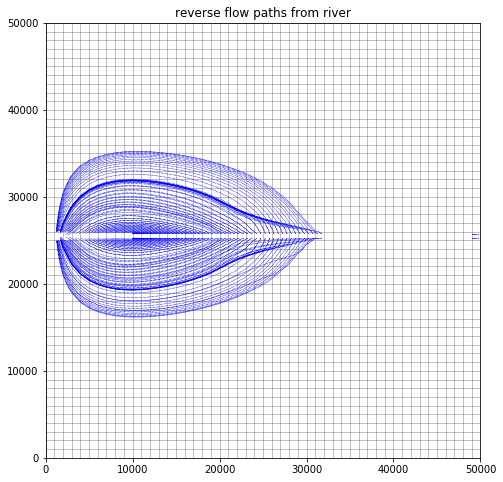

In [9]:
#f, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

#ax = axes[0]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax.set_aspect('equal')
ax.set_title('reverse flow paths from river')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label='river flowlines') #,marker='o', markercolor='black', markersize=3, markerevery=5)
#mm.plot_pathline(petzoneE2, layer='all', color='red', lw=0.5, linestyle=':', label='captured by well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)


## read in outputs

In [10]:
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')

head = headobj.get_alldata(nodata=-9.9998999e+02)
leakage = budgobj.get_data(text='RIVER LEAKAGE')

# #times = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]] #extract times at end of each stress period
# frf = {} #create dictionary to store flows through right cell face at end of each stress period
# fff = {} #create dictionary to store flows through front cell face at end of each stress period
# storage = {} #create dictionary to store storage at end of each stress period
# consthead = {} #create dictionary to store constant head boundary at end of each stress period
# leakage = {} #create dictionary to store leakage at end of each stress period

# headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
# budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

# #get data from python objects
# for stress_per, time in enumerate(times): #iterate through times at end of each stress period
#     head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
#     frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
#     fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
#     storage['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time) #append front face flow to fff list for ea stress per
#     consthead['sp%s'%(stress_per)] = budgobj.get_data(text='CONSTANT HEAD',totim=time) #append front face flow to fff list for ea stress per
#     leakage['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time) #append front face flow to fff list for ea stress per

In [11]:
type(leakage[0])
print(leakage)
print(leakage[0].q)
print(sum(leakage[0].q))

[rec.array([(1202,  4106.557    ), (1203,  2108.6667   ),
           (1204,  1506.0269   ), (1205,  1096.2759   ),
           (1206,   791.7413   ), (1207,   552.73975  ),
           (1208,   358.54004  ), (1209,   197.34409  ),
           (1210,    61.842888 ), (1211,   -52.75338  ),
           (1212,  -149.56664  ), (1213,  -230.42773  ),
           (1214,  -295.80084  ), (1215,  -343.87314  ),
           (1216,  -327.86298  ), (1217,  -383.51135  ),
           (1218,  -470.19275  ), (1219,  -605.9567   ),
           (1220, -1266.0437   ), (1221,  -347.48837  ),
           (1222,  -387.83847  ), (1223,  -459.56125  ),
           (1224,  -565.8993   ), (1225, -1022.91864  ),
           (1226,  -516.50757  ), (1227,  -380.9687   ),
           (1228,  -280.31427  ), (1229,  -198.02077  ),
           (1230,  -126.92075  ), (1231,   -63.28513  ),
           (1232,    -4.9453053), (1233,    49.511307 ),
           (1234,   101.09664  ), (1235,   150.59332  ),
           (1236,   198.64636 

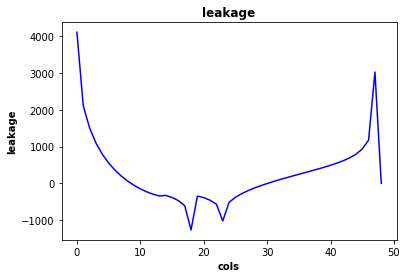

In [12]:
total_leakage = leakage[0].q
len(total_leakage)
cols = list(range(49))
len(cols)


plt.subplot(1, 1, 1)
plt.title("leakage",fontweight='bold')
plt.xlabel('cols',fontweight='bold')
plt.ylabel('leakage',fontweight='bold')
plt.plot(cols, total_leakage, 'b-') 

## Plots to make sure heads are okie dokie

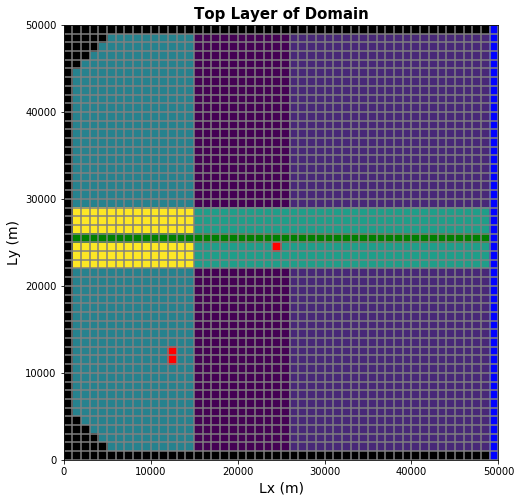

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(zones)
#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
quadmesh = modelmap.plot_bc('WEL')
#quadmesh = modelmap.plot_array(win_sq_array)
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound(ibound[0])



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Top Layer of Domain', fontsize = 15, fontweight = 'bold')
# plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
#                     mp.patches.Patch(color='white',label='Active Cell',ec='black'),
#                     mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
#                     mp.patches.Patch(color='red',label='well',ec='black'), 
#                     mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
#                     mp.patches.Patch(color='orange',label='Recharge',ec='black'),
#                     mp.patches.Patch(color='green',label='River',ec='black')])

#plt.show(modelmap)
plt.savefig('Domaingrid.png')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.


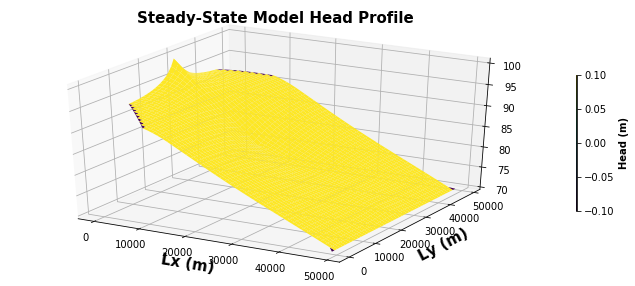

In [14]:

# print(head[0][0][27])
# print(head[0][1][27])
# print(head[0][2][27])

#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0][2])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=150).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
plt.show(surf)

# plt.figure(figsize=(9,9)) #create 10 x 10 figure
# modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
# #riv_plot = modelmap.plot_bc(ftype='RIV') #plot river cells
# #chd_plot = modelmap.plot_bc(ftype='CHD') #plot ghb cells
# contour_levels = np.linspace(70,95,1) #set contour levels for contouring head
# head_contours = modelmap.contour_array(head[0][0], masked_values=[-1.0000000e+30], levels=contour_levels) #create head contours
# #flows = modelmap.plot_discharge(frf['sp%s'%i][0], fff['sp%s'%i][0], head=head['sp%s'%i]) #create discharge arrows
# #display parameters
# plt.xlabel('Lx (m)',fontsize = 14)
# plt.ylabel('Ly (m)',fontsize = 14)
# plt.title('Head', fontsize = 13, fontweight = 'bold')
# plt.colorbar(head_contours)
# plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'), 
#                    mp.patches.Patch(color='navy',label='Constant Head Boundary',ec='black'),
#                    mp.patches.Patch(color='white',label='Active Cell',ec='black')],
#                    bbox_to_anchor=(1.8,1.0)) #create legend
# plt.show(modelmap)

[      nan       nan       nan       nan       nan 93.09546  92.92194
 92.63857  92.29591  91.89198  91.56039  91.158264 90.69772  90.184395
 89.62125  89.00994  88.396835 87.783424 87.171    86.56067  85.96487
 85.36979  84.77688  84.187256 83.60176  83.02101  82.44542  81.875244
 81.310585 80.751396 80.19751  79.648674 79.10452  78.56461  78.02846
 77.49549  76.96514  76.436775 75.909775 75.3835   74.857285 74.33048
 73.80244  73.27244  72.73977  72.20359  71.66296  71.11665  70.56309
 70.      ]


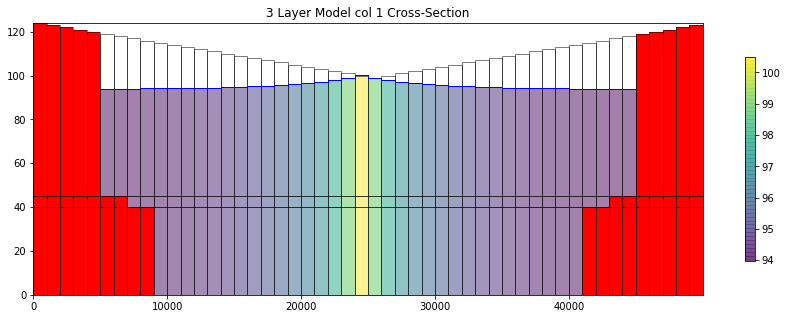

In [15]:

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 1}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
headpc = head[0]
pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model col 1 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0], color='blue', lw=1)

print(head[0][0][1][:])

[      nan       nan       nan       nan       nan 93.09546  92.92194
 92.63857  92.29591  91.89198  91.56039  91.158264 90.69772  90.184395
 89.62125  89.00994  88.396835 87.783424 87.171    86.56067  85.96487
 85.36979  84.77688  84.187256 83.60176  83.02101  82.44542  81.875244
 81.310585 80.751396 80.19751  79.648674 79.10452  78.56461  78.02846
 77.49549  76.96514  76.436775 75.909775 75.3835   74.857285 74.33048
 73.80244  73.27244  72.73977  72.20359  71.66296  71.11665  70.56309
 70.      ]


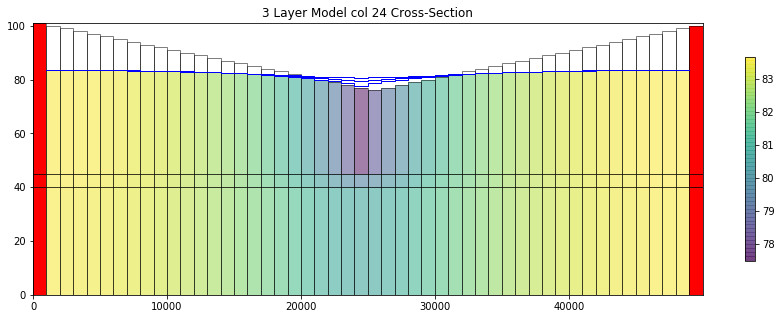

In [16]:

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 24}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
headpc = head[0]
pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model col 24 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0], color='blue', lw=1)

print(head[0][0][1][:])

[      nan       nan       nan       nan       nan 93.09546  92.92194
 92.63857  92.29591  91.89198  91.56039  91.158264 90.69772  90.184395
 89.62125  89.00994  88.396835 87.783424 87.171    86.56067  85.96487
 85.36979  84.77688  84.187256 83.60176  83.02101  82.44542  81.875244
 81.310585 80.751396 80.19751  79.648674 79.10452  78.56461  78.02846
 77.49549  76.96514  76.436775 75.909775 75.3835   74.857285 74.33048
 73.80244  73.27244  72.73977  72.20359  71.66296  71.11665  70.56309
 70.      ]


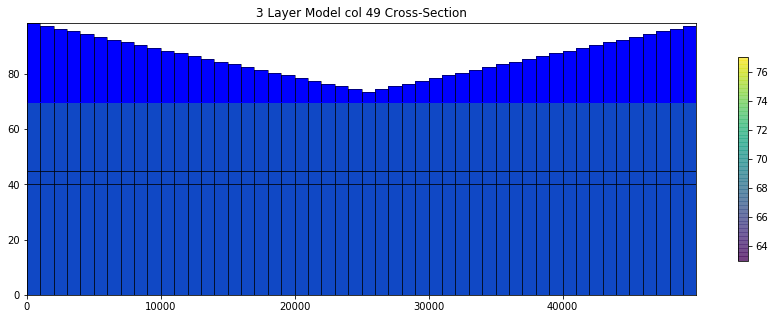

In [17]:

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 49}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
headpc = head[0]
pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model col 49 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0], color='blue', lw=1)

print(head[0][0][1][:])

[      nan       nan       nan       nan       nan 93.09546  92.92194
 92.63857  92.29591  91.89198  91.56039  91.158264 90.69772  90.184395
 89.62125  89.00994  88.396835 87.783424 87.171    86.56067  85.96487
 85.36979  84.77688  84.187256 83.60176  83.02101  82.44542  81.875244
 81.310585 80.751396 80.19751  79.648674 79.10452  78.56461  78.02846
 77.49549  76.96514  76.436775 75.909775 75.3835   74.857285 74.33048
 73.80244  73.27244  72.73977  72.20359  71.66296  71.11665  70.56309
 70.      ]


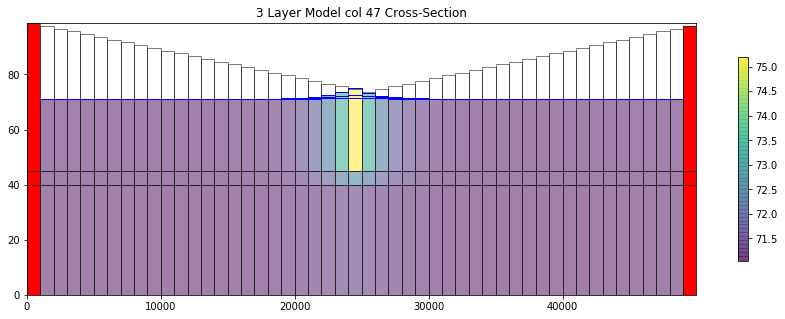

In [18]:

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 47}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
headpc = head[0]
pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model col 47 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0], color='blue', lw=1)

print(head[0][0][1][:])

## Head at wells

In [19]:
type(head)
head.shape
#print(head[0][0][well_loc[1]][well_loc[2]])
print(len(head[0][0]))

print("aquaseca well", head[0][0][int(well_row)][int(well_col)])
print("MW1", head[0][0][int(well2_row)][int(well2_col)])
print("MW2", head[0][0][int(well3_row)][int(well3_col)])
print("irrigation well", head[0][0][int(well4_row)][int(well4_col)])

50
aquaseca well 75.54741
MW1 78.575966
MW2 90.69416
irrigation well 90.71491
